## Visualizing NNAIF Surrogate Model Evolution: Noisy Rosenbrock ##
This notebook demonstrates how to use Neural Network Accelerated Implicit Filtering (NNAIF) to minimize a noise corrupted version of the Rosenbrock function that decomposes as
$$f(\mathbf{x}) = f_{s}(\mathbf{x}) + \phi(\mathbf{x})$$
where $f_{s}(\mathbf{x})$ is the standard (i.e. non-noisy) Rosenbrock function and $\phi(\mathbf{x})$ is noise. The notebook also visualizes how the NNAIF surrogate model $\widehat{f_{s}}(\mathbf{x},\mathbf{\Theta}_k)$ evolves when minimizing the noise corrupted version of the Rosenbrock function $f(\mathbf{x})$.

For a description of NNAIF, see the ICML 2023 paper 
"Neural Network Accelerated Implicit Filtering: Integrating Neural Network Surrogates With Provably Convergent Derivative Free Optimization Methods" by Brian Irwin, Eldad Haber, Raviv Gal, and Avi Ziv.

## Setting Up The Rosenbrock Function $f_{s}(\mathbf{x})$ Using PyCUTEst ##
Let's set up the Rosenbrock function $f_{s}(\mathbf{x})$ using the PyCUTEst python interface to the CUTEst optimization test environment (see https://jfowkes.github.io/pycutest). 

In [1]:
import pycutest


# CUTEst problem settings
problem_name = "ROSENBR"
sif_params = {}
cutest_problem = pycutest.import_problem(problem_name,
                                         sifParams=sif_params)

# Change the optimization starting point
cutest_problem.x0 = [-3,1]

# Print CUTEst problem information
print(pycutest.problem_properties(problem_name))
pycutest.print_available_sif_params(problem_name)

{'objective': 'sum of squares', 'constraints': 'unconstrained', 'regular': True, 'degree': 2, 'origin': 'academic', 'internal': False, 'n': 2, 'm': 0}
Parameters available for problem ROSENBR:
End of parameters for problem ROSENBR


## Adding Noise $\phi(\mathbf{x})$ To The Rosenbrock Function ##
Let's set up the noise $\phi(\mathbf{x})$ as zero mean Gaussian noise with a standard deviation $\sigma = 10$. Mathematically, $\phi(\mathbf{x}) \sim \mathcal{N}(0, 100)$.

In [2]:
from src import samplers


# Set up the objective function noise
obj_noise_dict = {"name":"gaussian random sampler",
                  "mu":0.0,
                  "sigma":10.0}
obj_noise_func = samplers.get_sampler(obj_noise_dict)

# Set up the objective gradient noise (zero radius is equivalent to no noise)
# NOTE: NNAIF never evaluates the objective gradient
grad_noise_dict = {"name":"spherical ball uniform random sampler",
                          "radius":0.0}
grad_noise_dict["dimension"] = cutest_problem.n
grad_noise_func = samplers.get_sampler(grad_noise_dict)

# Set number of samples over which to average function and gradient noise
num_samples = 1

## PyTorch Setup ##

In [3]:
import math
import numpy as np
import time
import torch


# Set PyTorch data type
dtype=torch.float

# Set initial seed for generating random numbers
seed = int(time.time())
np.random.seed(seed)
torch.manual_seed(seed)

# GPU setup
use_cuda = True

if use_cuda:
    device = 'cuda'
    torch.cuda.manual_seed_all(seed)
    assert torch.cuda.is_available(), 'CUDA is not available'
else:
    device = 'cpu'
    
# Print device
print("Running on device: {}".format(device))

Running on device: cuda


## Build The Noisy Rosenbrock Function $f(\mathbf{x})$  ##

In [4]:
from src import models


model = models.cutest.CUTEstProblemAdditiveNoise(cutest_problem,
                                                 obj_noise_func,
                                                 grad_noise_func,
                                                 dtype=dtype).to(device=device)

## NNAIF Optimizer Setup ##

In [5]:
from src import optimizers


# Dictionary storing NNAIF optimizer configuration
NNAIF_opt_dict = {"name":"NNAIF",
                  "alpha":1e0,
                  "h_0":4e0,
                  "h_min":1e-8,
                  "hessian approximation":"I",
                  "initial inverse hessian":"I",
                  "custom sampler":"spherical surface uniform random sampler",
                  "number of custom sampler directions":5,
                  "stencil type":"None",
                  "tau_tr":0.75,
                  "tau_gr":1e-2,
                  "h_min^surr":1e-2,
                  "eps_dec^surr":1e-3,
                  "line search starting step size":1e0,
                  "maximum number of line search objective closure evaluations":3,
                  "tau_ls":0.1,
                  "stencil wins?":True,
                  "stencil gradient beta":1e-5,
                  "number of points desired to pass surrogate filter test":1,
                  "maximum number of surrogate filtered sampling iterations":20,
                  "surrogate model dictionary":{"type":"RESNET EULER",
                                                "d_layer":50,
                                                "d_out":1,
                                                "number of square layers":5,
                                                "dt":1e-3,
                                                "sigma":1e-3},
                  "output transform dictionary":{"type":"I"},
                  "surrogate fit optimizer dictionary":{"name":"ADAM",
                                                        "alpha":1e0,
                                                        "amsgrad?":True,
                                                        "learning rate":1e0,
                                                        "betas0":0.9,
                                                        "betas1":0.999,
                                                        "loss function dictionary":{"name":"squared error"},
                                                        "parameter regularization dictionary":{"type":"Model Specific",
                                                                                               "alpha_x":1e-4,
                                                                                               "kwargs":{"regularization_type":"L2-All"}},
                                                        "model output regularizer dictionary":{"type":"None"},
                                                        "batch size":250,
                                                        "maximum number of epochs":250,
                                                        "loss tolerance":1e-3},
                  "surrogate descent optimizer dictionary":{"name":"ADAM",
                                                            "alpha":1e0,
                                                            "amsgrad?":True,
                                                            "learning rate":1e0,
                                                            "betas0":0.9,
                                                            "betas1":0.999,
                                                            "maximum number of surrogate descent iterations":20,
                                                            "norm order":None},
                  "verbose":False}

# Build PyTorch optimizer
opt = optimizers.get_optimizer(opt_dict=NNAIF_opt_dict,
                               model=model)

# Print PyTorch optimizer state
opt_state = opt.state[opt._params[0]]
print("Optimizer state:")
print(opt_state)

Optimizer state:
{'iteration count': 0, 'previous flat implicit filtering stencil gradient': None, 'previous best objective value': None, 'previous implicit filtering V': None, 'previous implicit filtering F': None, 'objective closure evaluation count': 0, 'previous iteration implicit filtering success?': False, 'line search objective closure evaluation count': 0, 'h': 4.0, 'stencil failure?': False, 'H': tensor([], device='cuda:0'), 'X': tensor([], device='cuda:0'), 'fs': tensor([], device='cuda:0')}


## Plot Magnitude Of Rosenbrock Function $|f_{s}(\mathbf{x})|$ ##

In [6]:
# Set up grid for plotting
n_x, n_y = (141, 141)
x_start, x_stop = (-9, 7)
x_vals = np.linspace(x_start, x_stop, n_x)
y_start, y_stop = (-5, 9)
y_vals = np.linspace(y_start, y_stop, n_y)
x_grid, y_grid = np.meshgrid(x_vals,y_vals,indexing='xy')
x_grid = torch.from_numpy(x_grid)
y_grid = torch.from_numpy(y_grid)

<function matplotlib.pyplot.show(close=None, block=None)>

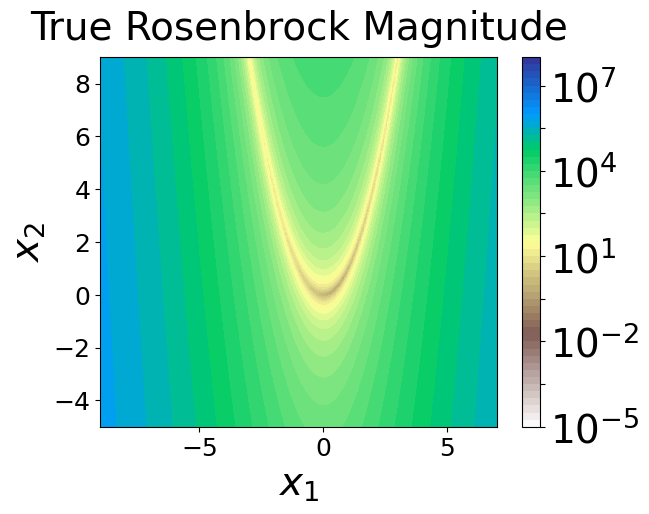

In [7]:
import matplotlib
import matplotlib.colors as colors
import matplotlib.pyplot as plt


# Calculate magnitude of non-noisy objective function over grid
z_obj = torch.zeros(n_x,n_y)
for i in range(n_x):
   for j in range(n_y):
       x_current = torch.tensor([x_grid[i,j], y_grid[i,j]], dtype=dtype).to(device=device)
       z_obj[i,j] = abs(model.get_true_obj(x_current))

# Visualize magnitude of non-noisy objective function over grid 
plt.figure()
cont = plt.contourf(x_grid, y_grid, z_obj.detach().numpy(), np.logspace(-5,8,53), cmap=plt.cm.terrain_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e8))
axes = plt.gca()
axes.tick_params(axis="x", labelsize=18)
axes.tick_params(axis="y", labelsize=18)
plt.xlabel(r"$x_1$", fontsize=28)
plt.ylabel(r"$x_2$", fontsize=28)
plt.title("True Rosenbrock Magnitude", y=1.025, fontsize=28)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=28)
axes.set_xlim([-9,7])
axes.set_ylim([-5,9])
plt.show

## Plot Magnitude Of Samples From Noisy Rosenbrock Function $|f(\mathbf{x})|$ ##

<function matplotlib.pyplot.show(close=None, block=None)>

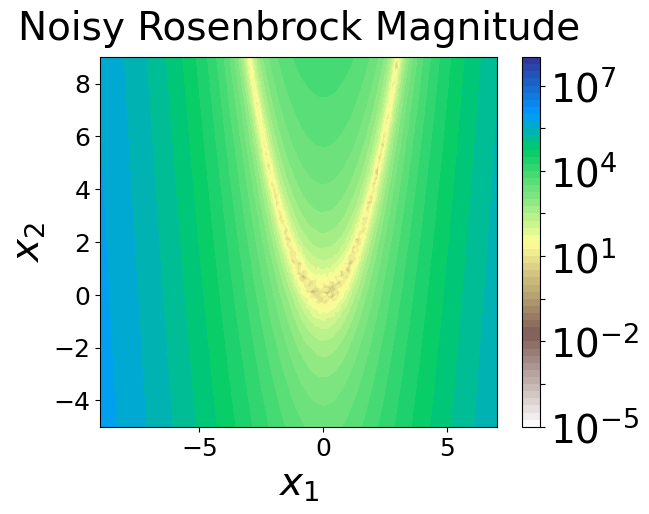

In [8]:
# Calculate magnitude of noisy objective function over grid
z_obj_noisy = torch.zeros(n_x,n_y)
for i in range(n_x):
   for j in range(n_y):
       x_current = torch.tensor([x_grid[i,j], y_grid[i,j]], dtype=dtype).to(device=device)
       z_obj_noisy[i,j] = abs(model.get_true_obj(x_current) + 10*np.random.randn())

# Visualize magnitude of noisy objective function over grid 
plt.figure()
cont = plt.contourf(x_grid, y_grid, z_obj_noisy.detach().numpy(), np.logspace(-5,8,53), cmap=plt.cm.terrain_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e8))
axes = plt.gca()
axes.tick_params(axis="x", labelsize=18)
axes.tick_params(axis="y", labelsize=18)
plt.xlabel(r"$x_1$", fontsize=28)
plt.ylabel(r"$x_2$", fontsize=28)
plt.title("Noisy Rosenbrock Magnitude", y=1.025, fontsize=28)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=28)
axes.set_xlim([-9,7])
axes.set_ylim([-5,9])
plt.show

## Initial NNAIF Iteration ##

In [9]:
from run_cutest_experiments import opt_step


# Print number of initial training data points
print("Number of initial training data points: {}".format(NNAIF_opt_dict["number of custom sampler directions"]+1))

# NNAIF optimization
model.train()
print("Optimizing {} using {} ...".format(problem_name, NNAIF_opt_dict["name"]))

start_time = time.time()
opt_step(NNAIF_opt_dict, 
         opt,
         model, 
         num_samples)
end_time = time.time()
print("Optimization time (seconds): {}".format(end_time - start_time))

# Print PyTorch optimizer state
opt_state = opt.state[opt._params[0]]
print("Optimizer state:")
print(opt_state)

Number of initial training data points: 6
Optimizing ROSENBR using NNAIF ...


/home/birwin/Desktop/testing/NNAIF/src/models/cutest.py:99: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grad_sum += true_grad_tensor + torch.tensor(grad_noise_func(),
/home/birwin/Desktop/testing/NNAIF/src/models/cutest.py:106: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  torch_obj = torch.tensor(obj,


Optimization time (seconds): 2.512317419052124
Optimizer state:
{'iteration count': 1, 'previous flat implicit filtering stencil gradient': tensor([-599.2356, -178.5911], device='cuda:0'), 'previous best objective value': 913.3348999023438, 'previous implicit filtering V': tensor([[-0.6556, -0.3200,  0.4557, -0.4305,  0.5235],
        [-0.7551,  0.9474,  0.8901,  0.9026, -0.8520]], device='cuda:0'), 'previous implicit filtering F': tensor([5177.3149, 2528.2012, 1201.8492, 1210.0348, 2065.4199],
       device='cuda:0'), 'objective closure evaluation count': 12, 'previous iteration implicit filtering success?': True, 'line search objective closure evaluation count': 0, 'h': 4.0, 'stencil failure?': False, 'H': tensor([], device='cuda:0'), 'X': tensor([[-3.0000e+00, -6.9530e+00,  9.0079e-01, -3.0253e+00, -4.6001e+00,
         -1.1005e+00, -5.7220e-02, -2.6797e+00, -1.3372e+00,  1.7656e+00,
         -1.7792e+00,  2.0369e+00],
        [ 1.0000e+00,  1.6117e+00,  1.1464e-01, -2.9999e+00, -2.

## Visualize Initial NNAIF Surrogate Model $\widehat{f_{s}}(\mathbf{x},\mathbf{\Theta}_0)$ ##

In [10]:
# Calculate magnitude of NNAIF surrogate model of objective function over grid
z_NN = torch.zeros(n_x,n_y)
for i in range(n_x):
   for j in range(n_y):
       x_current = torch.tensor([x_grid[i,j], y_grid[i,j]], dtype=dtype).to(device=device)
       x_current = x_current.unsqueeze(1)
       z_NN[i,j] = abs(opt._surrogate_model(x_current))

<function matplotlib.pyplot.show(close=None, block=None)>

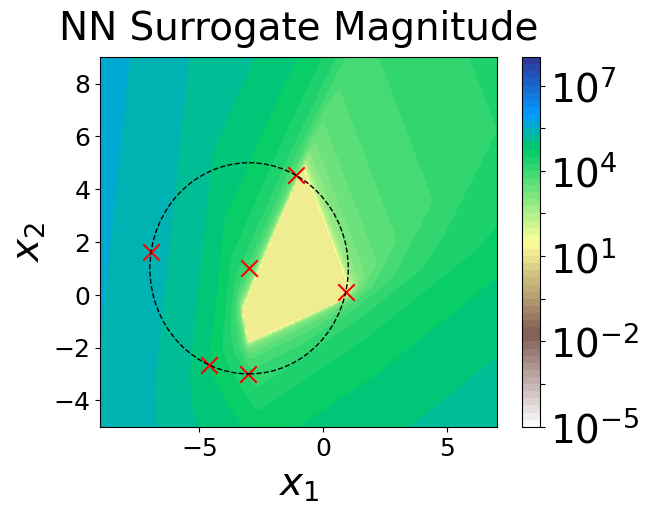

In [11]:
# Visualize magnitude of NNAIF surrogate model of objective function over grid 
plt.figure()
cont = plt.contourf(x_grid, y_grid, z_NN.detach().numpy(), np.logspace(-5,8,53), cmap=plt.cm.terrain_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e8))
axes = plt.gca()
axes.tick_params(axis="x", labelsize=18)
axes.tick_params(axis="y", labelsize=18)
plt.xlabel(r"$x_1$", fontsize=28)
plt.ylabel(r"$x_2$", fontsize=28)
plt.title("NN Surrogate Magnitude", y=1.025, fontsize=28)
cbar = plt.colorbar()
cbar.ax.tick_params(labelsize=28)

# Mark initial training data points via red x marks
Xs = opt_state["X"].cpu()
for i in range(NNAIF_opt_dict["number of custom sampler directions"]+1):
    plt.scatter(Xs[0,i], Xs[1,i], color="red", marker="x", s=[140])
    
# Mark boundary of initial trust region
tr_region = plt.Circle(cutest_problem.x0, NNAIF_opt_dict["h_0"], ls="--", color="black", fill=False)
axes.add_patch(tr_region)

axes.set_xlim([-9,7])
axes.set_ylim([-5,9])
plt.show

## Loop Visualizing Further NNAIF Iterations ##

Iteration 1
Optimization time (seconds): 1.8871064186096191
Optimizer state:
{'iteration count': 2, 'previous flat implicit filtering stencil gradient': tensor([-669.3140,  380.4688], device='cuda:0'), 'previous best objective value': 123.60441589355469, 'previous implicit filtering V': tensor([[ 0.4438,  0.8171, -0.4092,  0.1256, -0.8863],
        [-0.8961,  0.5766, -0.9125,  0.9921,  0.4632]], device='cuda:0'), 'previous implicit filtering F': tensor([ 2976.6938,  4793.3140,  2971.5393,  2362.2847, 10121.6055],
       device='cuda:0'), 'objective closure evaluation count': 6, 'previous iteration implicit filtering success?': True, 'line search objective closure evaluation count': 0, 'h': 4.0, 'stencil failure?': False, 'H': tensor([], device='cuda:0'), 'X': tensor([[-3.0000e+00, -6.9530e+00,  9.0079e-01, -3.0253e+00, -4.6001e+00,
         -1.1005e+00, -5.7220e-02, -2.6797e+00, -1.3372e+00,  1.7656e+00,
         -1.7792e+00,  2.0369e+00, -5.8105e-02,  1.7172e+00,  3.2101e+00,
        

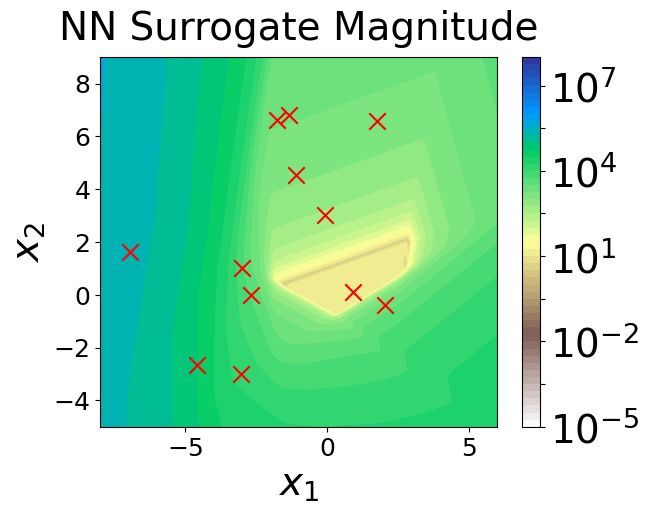

Iteration 2
Optimization time (seconds): 1.927976369857788
Optimizer state:
{'iteration count': 3, 'previous flat implicit filtering stencil gradient': tensor([446.9926, 387.1456], device='cuda:0'), 'previous best objective value': 123.60441589355469, 'previous implicit filtering V': tensor([[ 0.8784,  0.9352,  0.3871,  0.1898, -0.8261],
        [ 0.4779,  0.3542, -0.9221,  0.9818,  0.5635]], device='cuda:0'), 'previous implicit filtering F': tensor([1698.1838, 2916.4031,  835.2253, 1413.6790, 1346.0663],
       device='cuda:0'), 'objective closure evaluation count': 6, 'previous iteration implicit filtering success?': True, 'line search objective closure evaluation count': 0, 'h': 3.0, 'stencil failure?': True, 'H': tensor([], device='cuda:0'), 'X': tensor([[-3.0000e+00, -6.9530e+00,  9.0079e-01, -3.0253e+00, -4.6001e+00,
         -1.1005e+00, -5.7220e-02, -2.6797e+00, -1.3372e+00,  1.7656e+00,
         -1.7792e+00,  2.0369e+00, -5.8105e-02,  1.7172e+00,  3.2101e+00,
         -1.6948e

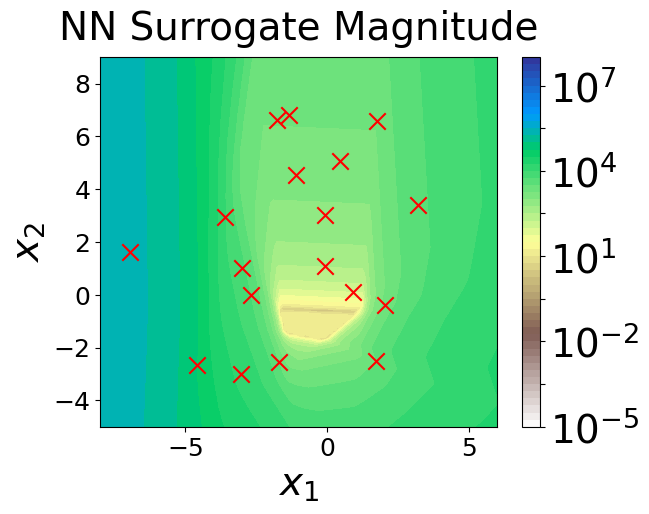

Iteration 3
Optimization time (seconds): 1.9352359771728516
Optimizer state:
{'iteration count': 4, 'previous flat implicit filtering stencil gradient': tensor([-1335.2935, -1018.5969], device='cuda:0'), 'previous best objective value': 86.83142852783203, 'previous implicit filtering V': tensor([[-0.3333, -0.6093, -0.7719,  0.2393,  0.9209],
        [ 0.9428, -0.7929,  0.6358, -0.9710, -0.3897]], device='cuda:0'), 'previous implicit filtering F': tensor([  18.6878, 8047.5967, 5369.7783, 1185.2291, 3873.6191],
       device='cuda:0'), 'objective closure evaluation count': 6, 'previous iteration implicit filtering success?': True, 'line search objective closure evaluation count': 0, 'h': 3.0, 'stencil failure?': True, 'H': tensor([], device='cuda:0'), 'X': tensor([[-3.0000e+00, -6.9530e+00,  9.0079e-01, -3.0253e+00, -4.6001e+00,
         -1.1005e+00, -5.7220e-02, -2.6797e+00, -1.3372e+00,  1.7656e+00,
         -1.7792e+00,  2.0369e+00, -5.8105e-02,  1.7172e+00,  3.2101e+00,
         -1.6

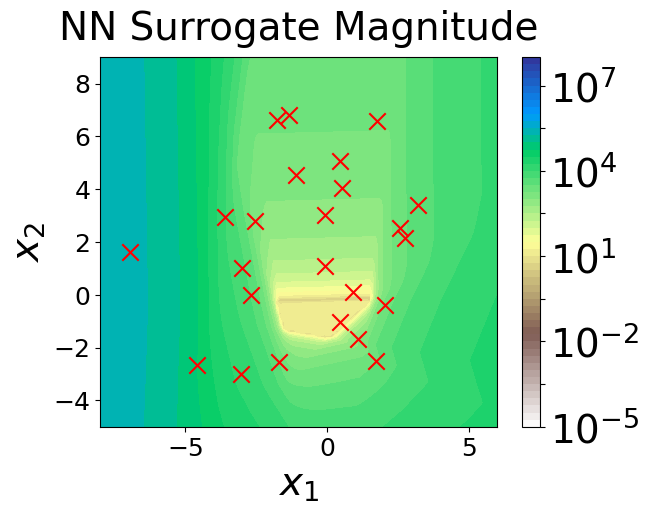

Iteration 4
Optimization time (seconds): 1.9709031581878662
Optimizer state:
{'iteration count': 5, 'previous flat implicit filtering stencil gradient': tensor([1.7122e+00, 3.5741e+03], device='cuda:0'), 'previous best objective value': 18.687789916992188, 'previous implicit filtering V': tensor([[ 0.7642, -0.8167, -0.6198,  0.9609, -0.7179],
        [-0.6450,  0.5771,  0.7847, -0.2767,  0.6962]], device='cuda:0'), 'previous implicit filtering F': tensor([   21.7618, 16033.1631,  5736.1689,    22.0213,  9952.0742],
       device='cuda:0'), 'objective closure evaluation count': 9, 'previous iteration implicit filtering success?': True, 'line search objective closure evaluation count': 3, 'h': 3.0, 'stencil failure?': False, 'H': tensor([], device='cuda:0'), 'X': tensor([[-3.0000e+00, -6.9530e+00,  9.0079e-01, -3.0253e+00, -4.6001e+00,
         -1.1005e+00, -5.7220e-02, -2.6797e+00, -1.3372e+00,  1.7656e+00,
         -1.7792e+00,  2.0369e+00, -5.8105e-02,  1.7172e+00,  3.2101e+00,
      

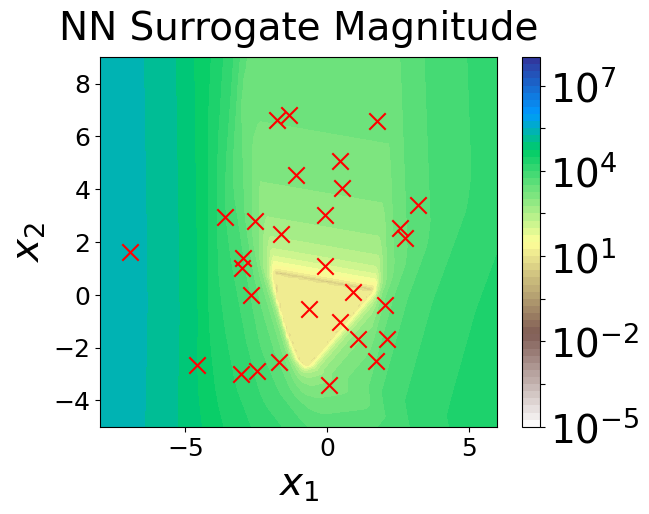

Iteration 5
Optimization time (seconds): 1.803102731704712
Optimizer state:
{'iteration count': 6, 'previous flat implicit filtering stencil gradient': tensor([  955.7942, -2240.0967], device='cuda:0'), 'previous best objective value': 15.880489349365234, 'previous implicit filtering V': tensor([[-0.6214, -0.9952, -0.9750,  0.9434, -0.8483],
        [-0.7835,  0.0978,  0.2220, -0.3318, -0.5296]], device='cuda:0'), 'previous implicit filtering F': tensor([  885.9110,  1840.5895,  1326.5215, 15291.3926,  1861.8698],
       device='cuda:0'), 'objective closure evaluation count': 6, 'previous iteration implicit filtering success?': True, 'line search objective closure evaluation count': 0, 'h': 3.0, 'stencil failure?': False, 'H': tensor([], device='cuda:0'), 'X': tensor([[-3.0000e+00, -6.9530e+00,  9.0079e-01, -3.0253e+00, -4.6001e+00,
         -1.1005e+00, -5.7220e-02, -2.6797e+00, -1.3372e+00,  1.7656e+00,
         -1.7792e+00,  2.0369e+00, -5.8105e-02,  1.7172e+00,  3.2101e+00,
       

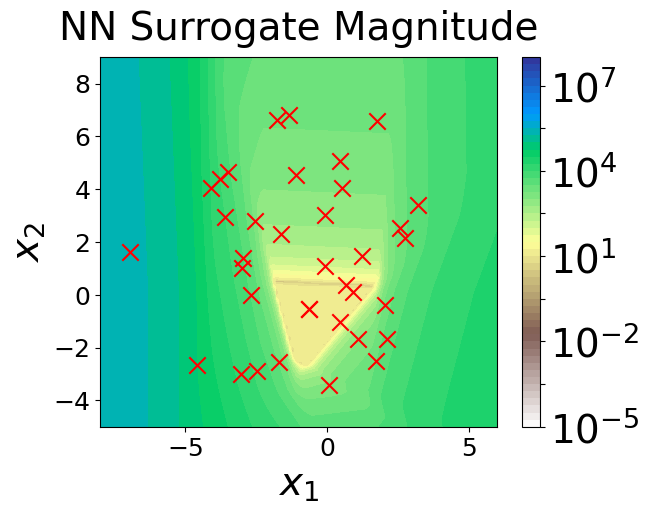

Iteration 6
Optimization time (seconds): 2.0591087341308594
Optimizer state:
{'iteration count': 7, 'previous flat implicit filtering stencil gradient': tensor([2066.4998,  226.2420], device='cuda:0'), 'previous best objective value': 2.1609911918640137, 'previous implicit filtering V': tensor([[-0.1571, -0.5580,  0.5798,  0.9995,  0.9997],
        [ 0.9876,  0.8299,  0.8147, -0.0331, -0.0260]], device='cuda:0'), 'previous implicit filtering F': tensor([ 774.7513,   14.9110,   34.6550, 8284.7871, 8252.8789],
       device='cuda:0'), 'objective closure evaluation count': 6, 'previous iteration implicit filtering success?': True, 'line search objective closure evaluation count': 0, 'h': 3.0, 'stencil failure?': False, 'H': tensor([], device='cuda:0'), 'X': tensor([[-3.0000e+00, -6.9530e+00,  9.0079e-01, -3.0253e+00, -4.6001e+00,
         -1.1005e+00, -5.7220e-02, -2.6797e+00, -1.3372e+00,  1.7656e+00,
         -1.7792e+00,  2.0369e+00, -5.8105e-02,  1.7172e+00,  3.2101e+00,
         -1.6

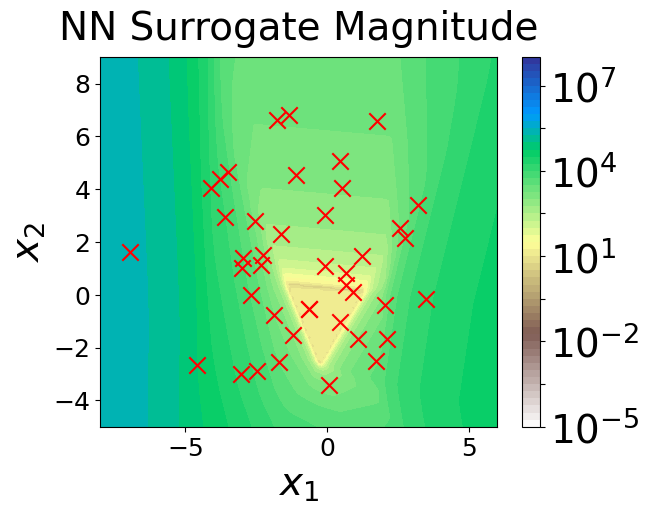

Iteration 7
Optimization time (seconds): 2.0623421669006348
Optimizer state:
{'iteration count': 8, 'previous flat implicit filtering stencil gradient': tensor([-324.8225, -973.1953], device='cuda:0'), 'previous best objective value': -11.475743293762207, 'previous implicit filtering V': tensor([[-0.7774,  0.8899,  0.1804, -0.8714, -0.1981],
        [-0.6291, -0.4562,  0.9836, -0.4905,  0.9802]], device='cuda:0'), 'previous implicit filtering F': tensor([5274.6772, 7216.5078,  706.4117, 6790.5020,  679.4686],
       device='cuda:0'), 'objective closure evaluation count': 6, 'previous iteration implicit filtering success?': True, 'line search objective closure evaluation count': 0, 'h': 3.0, 'stencil failure?': False, 'H': tensor([], device='cuda:0'), 'X': tensor([[-3.0000e+00, -6.9530e+00,  9.0079e-01, -3.0253e+00, -4.6001e+00,
         -1.1005e+00, -5.7220e-02, -2.6797e+00, -1.3372e+00,  1.7656e+00,
         -1.7792e+00,  2.0369e+00, -5.8105e-02,  1.7172e+00,  3.2101e+00,
         -1.

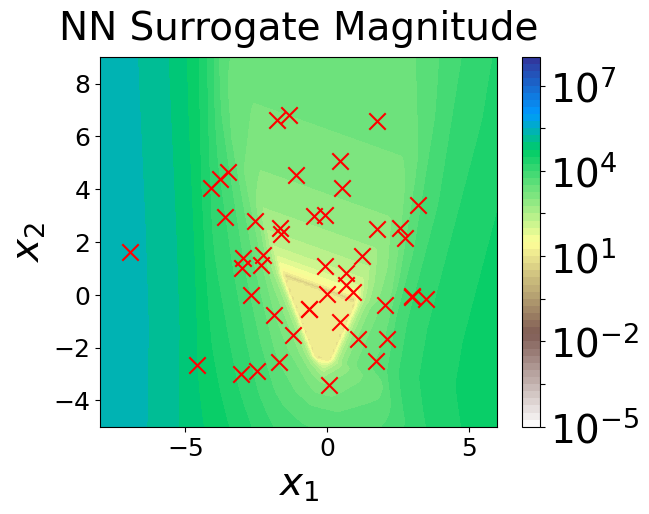

Iteration 8
Optimization time (seconds): 2.1203770637512207
Optimizer state:
{'iteration count': 9, 'previous flat implicit filtering stencil gradient': tensor([188.9043,  21.8012], device='cuda:0'), 'previous best objective value': -11.475743293762207, 'previous implicit filtering V': tensor([[-0.0733, -0.2327,  0.4358,  0.5329,  0.7813],
        [ 0.9973,  0.9726, -0.9001,  0.8462,  0.6242]], device='cuda:0'), 'previous implicit filtering F': tensor([501.0092, 376.8547, 875.2189,  16.7752, 276.1435], device='cuda:0'), 'objective closure evaluation count': 6, 'previous iteration implicit filtering success?': True, 'line search objective closure evaluation count': 0, 'h': 2.25, 'stencil failure?': True, 'H': tensor([], device='cuda:0'), 'X': tensor([[-3.0000e+00, -6.9530e+00,  9.0079e-01, -3.0253e+00, -4.6001e+00,
         -1.1005e+00, -5.7220e-02, -2.6797e+00, -1.3372e+00,  1.7656e+00,
         -1.7792e+00,  2.0369e+00, -5.8105e-02,  1.7172e+00,  3.2101e+00,
         -1.6948e+00,  4.4

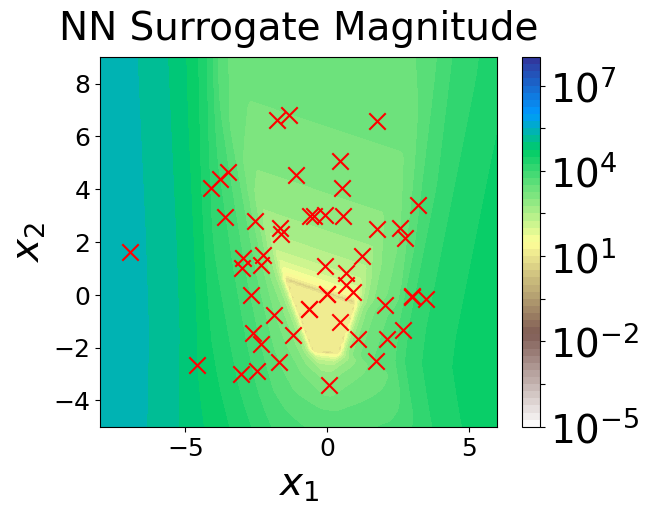

Iteration 9
Optimization time (seconds): 2.1064913272857666
Optimizer state:
{'iteration count': 10, 'previous flat implicit filtering stencil gradient': tensor([-379.9374,   96.9889], device='cuda:0'), 'previous best objective value': -11.475743293762207, 'previous implicit filtering V': tensor([[-0.3900, -0.9483,  0.5539,  0.6042, -0.9631],
        [-0.9208, -0.3173,  0.8326,  0.7968,  0.2691]], device='cuda:0'), 'previous implicit filtering F': tensor([390.5574, 941.9956,  38.6690,  18.8514, 471.1952], device='cuda:0'), 'objective closure evaluation count': 6, 'previous iteration implicit filtering success?': True, 'line search objective closure evaluation count': 0, 'h': 1.6875, 'stencil failure?': True, 'H': tensor([], device='cuda:0'), 'X': tensor([[-3.0000e+00, -6.9530e+00,  9.0079e-01, -3.0253e+00, -4.6001e+00,
         -1.1005e+00, -5.7220e-02, -2.6797e+00, -1.3372e+00,  1.7656e+00,
         -1.7792e+00,  2.0369e+00, -5.8105e-02,  1.7172e+00,  3.2101e+00,
         -1.6948e+00,

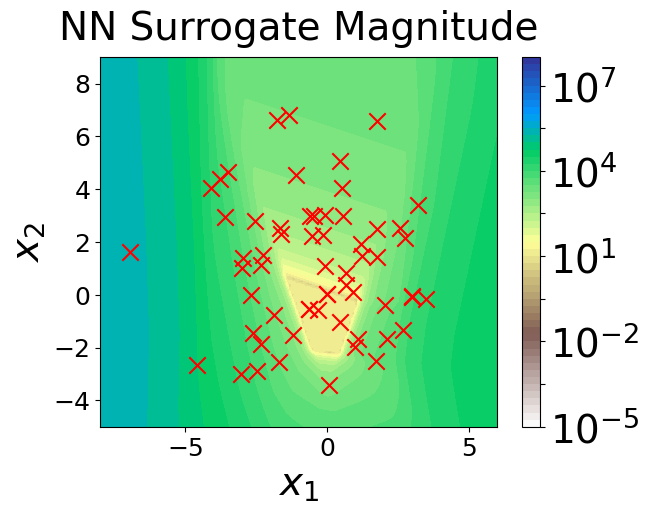

Iteration 10
Optimization time (seconds): 2.2301063537597656
Optimizer state:
{'iteration count': 11, 'previous flat implicit filtering stencil gradient': tensor([ -29.9417, -246.1956], device='cuda:0'), 'previous best objective value': -11.475743293762207, 'previous implicit filtering V': tensor([[-0.6674,  0.9289, -0.1726, -0.7531, -0.9946],
        [-0.7447, -0.3705, -0.9850, -0.6579,  0.1039]], device='cuda:0'), 'previous implicit filtering F': tensor([264.7248, 338.0073, 161.2842, 292.8606, 203.4480], device='cuda:0'), 'objective closure evaluation count': 6, 'previous iteration implicit filtering success?': True, 'line search objective closure evaluation count': 0, 'h': 1.265625, 'stencil failure?': True, 'H': tensor([], device='cuda:0'), 'X': tensor([[-3.0000e+00, -6.9530e+00,  9.0079e-01, -3.0253e+00, -4.6001e+00,
         -1.1005e+00, -5.7220e-02, -2.6797e+00, -1.3372e+00,  1.7656e+00,
         -1.7792e+00,  2.0369e+00, -5.8105e-02,  1.7172e+00,  3.2101e+00,
         -1.6948e+

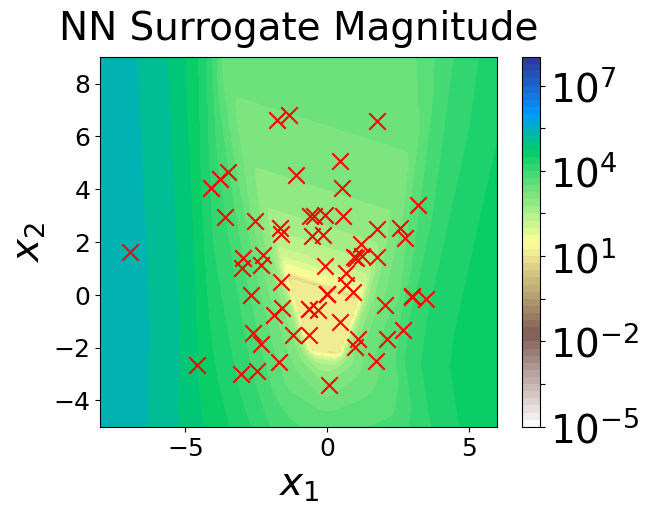

In [12]:
num_iterations = 10
for k in range(num_iterations):
    
    print("Iteration {}".format(k+1))
    
    # Store training data points
    opt_state = opt.state[opt._params[0]]
    Xs = opt_state["X"].cpu()
    
    # NNAIF optimization
    start_time = time.time()
    opt_step(NNAIF_opt_dict, 
             opt,
             model, 
             num_samples)
    end_time = time.time()
    print("Optimization time (seconds): {}".format(end_time - start_time))
    
    # Calculate magnitude of NNAIF surrogate model of objective function over grid
    z_NN = torch.zeros(n_x,n_y)
    for i in range(n_x):
       for j in range(n_y):
           x_current = torch.tensor([x_grid[i,j], y_grid[i,j]], dtype=dtype).to(device=device)
           x_current = x_current.unsqueeze(1)
           z_NN[i,j] = abs(opt._surrogate_model(x_current))

    # Visualize magnitude of NNAIF surrogate model of objective function over grid
    plt.figure(k+1)
    cont = plt.contourf(x_grid, y_grid, z_NN.detach().numpy(), np.logspace(-5,8,53), cmap=plt.cm.terrain_r, norm=colors.LogNorm(vmin=1e-5, vmax=1e8))
    axes = plt.gca()
    axes.tick_params(axis="x", labelsize=18)
    axes.tick_params(axis="y", labelsize=18)
    plt.xlabel(r"$x_1$", fontsize=28)
    plt.ylabel(r"$x_2$", fontsize=28)
    plt.title("NN Surrogate Magnitude", y=1.025, fontsize=28)
    cbar = plt.colorbar()
    cbar.ax.tick_params(labelsize=28)
    
    # Mark training data points via red x marks
    for i in range(Xs.shape[1]):
        plt.scatter(Xs[0,i], Xs[1,i], color="red", marker="x", s=[140])

    axes.set_xlim([-8,6])
    axes.set_ylim([-5,9])
    plt.show
    
    # Print PyTorch optimizer state
    print("Optimizer state:")
    print(opt.state[opt._params[0]])
    
    plt.pause(1)